#### Q1: Saturation timing
1. Forecast a central scenario for the network on the current trajectory. Define saturation threshold as when NetworkQAP becomes Yx greater than NetworkRBP, where Y is based on the terminal FIL+ rate.  What date is does this happen?
2. How does this date change across onboarding scenarios: RBPonboarding in {2,4,6,8,10}PiB/day and FIL+ rate in {50, 75, 100}%

#### Q2: Macro sunset
1. Compare three main macro scenarios: (i) no change (ii) FIL+ rate = 100% (iii) FIL+ rate = 0%. For scenarios (ii) and (iii) simulate the central scenario up to the saturation threshold, then introduce a change point in the FIL+ rate to simulate sunsetting.
2. For each of the two counterfactual sunset scenarios (ii) and (iii), show variations where the assumed raw-byte onboarding after the change is {5,10,15,20,25}PiB/day

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpyro

NDEVICES = 4 
numpyro.set_host_device_count(NDEVICES)

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

from cel_utils import disk_utils

In [4]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/filp_saturation')
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [5]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

current_date = date(2023,7,28) - timedelta(days=3)
start_date = date(current_date.year, current_date.month, 1)
forecast_length = 365*9
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-25 2032-07-22


In [6]:
def generate_mcmc_forecast_samples(train_start_date: date,
                                   train_end_date: date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose = verbose)
#     print("Forecasting Renewal Rate")
#     forecast_rr_date_vec, renewal_rate_pred, historical_rr_date , historical_rr, ext_rhats, expire_rhats = \
#         mcmc.forecast_renewal_rate(train_start_date, 
#                                    train_end_date,
#                                    forecast_length,
#                                    num_warmup_mcmc = num_warmup_mcmc,
#                                    num_samples_mcmc = num_samples_mcmc,
#                                    seasonality_mcmc = seasonality_mcmc,
#                                    num_chains_mcmc = num_chains_mcmc,
#                                    verbose = verbose)
    
    diagnostics = {
        'rb_rhats': rb_rhats,
#         'ext_rhats': ext_rhats,
#         'expire_rhats': expire_rhats,
    }
    
#     return rb_onboard_power_pred, renewal_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, diagnostics
    return rb_onboard_power_pred, historical_rb_date, historical_rb, diagnostics

In [7]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = current_date - timedelta(days=(mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 30000
num_samples_mcmc = 1000
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [8]:
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date)
day_vec = np.arange(0,len(hist_fpr))

In [9]:
@disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    rb_onboard_power_pred, historical_rb_date, historical_rb, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc,
                                       verbose=True)
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'diagnostics': diagnostics
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

# print mcmc diagnostics
rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))

Forecasting Onboarding Power


  0%|          | 0/31000 [00:00<?, ?it/s]

  0%|          | 0/31000 [00:00<?, ?it/s]

  0%|          | 0/31000 [00:00<?, ?it/s]

  0%|          | 0/31000 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.02      0.03      0.01     -0.01      0.06    105.93      1.04
       init_s[0]     -0.35     11.90     -0.00    -10.52     12.31    262.74      1.01
       init_s[1]     -0.53      0.10     -0.53     -0.70     -0.38   1311.01      1.00
       init_s[2]     -0.30      0.11     -0.29     -0.48     -0.13   1144.34      1.00
       init_s[3]     -0.37      0.11     -0.36     -0.57     -0.22   1205.25      1.00
       init_s[4]     -0.32      0.12     -0.31     -0.49     -0.13   1467.20      1.00
       init_s[5]     -0.22      0.12     -0.21     -0.41     -0.04    929.18      1.00
       init_s[6]     -0.06      0.13     -0.06     -0.25      0.12   1055.69      1.00
       init_s[7]      0.57      0.13      0.58      0.36      0.77    596.63      1.00
       init_s[8]      1.07      0.13      1.08      0.85      1.26    481.47      1.00
       init_s[9]      1.57      0.13      

RBP Forecast RHat < 1.05: 98.42 %


<IPython.core.display.Javascript object>


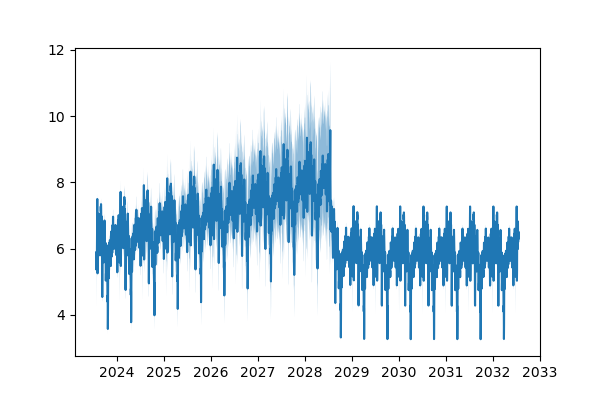

In [10]:
plt.figure(figsize=(6,4))

t_fcast = du.get_t(current_date, forecast_length=forecast_length)
q = np.quantile(rb_onboard_power_pred, q=[0.05, 0.25, 0.5, 0.75, 0.95], axis=0)
plt.plot(t_fcast, q[2])
plt.fill_between(t_fcast, q[1], q[3], alpha=0.5)

In [11]:
# logistic model for FPR forecast
def fpr_logistic_growth_model(x, y=None):
    # priors
    x0 = numpyro.sample("x0", dist.Normal(x.shape[0] // 2, 50)) # midpoint
    k = numpyro.sample("k", dist.Normal(0, 0.1)) # growth rate
    L = numpyro.sample("L", dist.Beta(1, 1)) # carrying capacity
    
    # logistic model
    filp = numpyro.deterministic("filp", L / (1 + jnp.exp(-k * (x - x0))))
    
    # Bernoulli likelihood version
    numpyro.sample(
        "obs",
        dist.Bernoulli(probs=filp),
        obs=y,
    )

In [12]:
def model_filp():
    filp_mcmc = MCMC(
        NUTS(fpr_logistic_growth_model, dense_mass=True),
        num_warmup=num_warmup_mcmc,
        num_samples=num_samples_mcmc,
        num_chains=num_chains_mcmc,
        progress_bar=True,
    )
    filp_mcmc.run(PRNGKey(1), x=day_vec, y=hist_fpr)
    filp_mcmc.print_summary()

    return {'filp_mcmc': filp_mcmc}

filp_data = model_filp()
locals().update(filp_data)

  0%|          | 0/31000 [00:00<?, ?it/s]

  0%|          | 0/31000 [00:00<?, ?it/s]

  0%|          | 0/31000 [00:00<?, ?it/s]

  0%|          | 0/31000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.90      0.05      0.90      0.82      0.99   1341.79      1.00
         k      0.02      0.00      0.01      0.01      0.02   1637.18      1.00
        x0    519.30     15.31    519.89    495.15    544.34   1351.82      1.00

Number of divergences: 0


In [13]:
predictive = Predictive(fpr_logistic_growth_model, filp_mcmc.get_samples())
preds = predictive(PRNGKey(1), x=day_vec)["obs"]

In [14]:
carrying_capacity = filp_mcmc.get_samples()['L']
print("Carrying capacity mean and [Q10,Q90]:")
mu_L, q10q90_L = jnp.median(carrying_capacity),  jnp.percentile(carrying_capacity,  jnp.array([10, 90]), 0)
mu_L, q10q90_L

Carrying capacity mean and [Q10,Q90]:


(Array(0.89929366, dtype=float32),
 Array([0.8239545 , 0.97006446], dtype=float32))

<IPython.core.display.Javascript object>


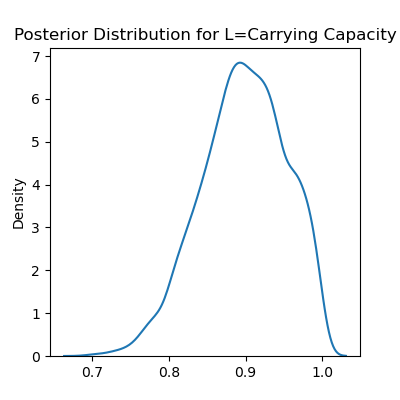

In [15]:
plt.figure(figsize=(4,4))
sns.kdeplot(carrying_capacity)
plt.title('Posterior Distribution for L=Carrying Capacity')
plt.savefig(os.path.join(save_dir, 'L_posterior.png'))

In [16]:
# for each trajectory, run mechaFIL and plot metrics: QAP/RBP
central_scenarios = []

lock_target = 0.3
sector_duration = 540
smooth_historical_rr = np.median(hist_rr[-90:])

for ii in tqdm(range(num_chains_mcmc*num_samples_mcmc)):
    rbp = rb_onboard_power_pred[ii]
    rr = jnp.ones(forecast_length) * smooth_historical_rr
    L = carrying_capacity[ii]
    fpr = jnp.ones(forecast_length) * L

    simulation_results = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    
    central_scenarios.append(simulation_results)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [17]:
def compute_quantiles(results, keys=['network_RBP_EIB'], xform=None, q=[0.05, 0.25, 0.50, 0.75, 0.95], startidx=None, endidx=None):
    key_vec = []
    for r in results:
        tmp_res = []
        for k in keys:
            tmp_res.append(r[k])
            
        if xform is None:
            key_vec.append(tmp_res[0])
        else:
            xx = xform(tmp_res)
            if xx is not None:
                key_vec.append(xx)
    key_vec = np.asarray(key_vec)
    if startidx is not None:
        key_vec = key_vec[:, startidx:]
    if endidx is not None:
        key_vec = key_vec[:, 0:endidx]
    return np.nanquantile(key_vec, q, axis=0)

In [18]:
t = du.get_t(start_date, end_date=end_date)

<IPython.core.display.Javascript object>


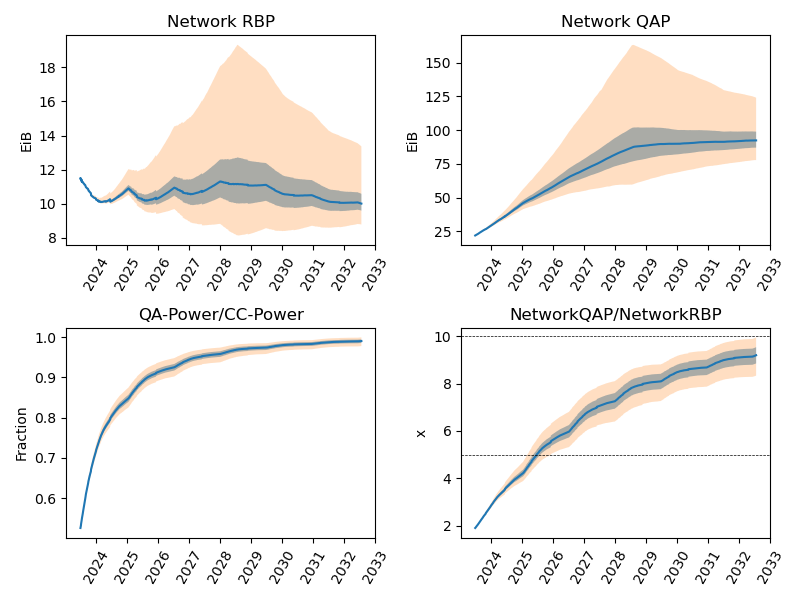

In [19]:
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
q = compute_quantiles(central_scenarios, keys=['network_RBP_EIB'])
plt.plot(t, q[2])
plt.fill_between(t, q[1], q[3], alpha=0.5)
plt.fill_between(t, q[0], q[4], alpha=0.25)
plt.xticks(rotation=60)
plt.title('Network RBP')
plt.ylabel('EiB')

plt.subplot(2,2,2)
q = compute_quantiles(central_scenarios, keys=['network_QAP_EIB'])
plt.plot(t, q[2])
plt.fill_between(t, q[1], q[3], alpha=0.5)
plt.fill_between(t, q[0], q[4], alpha=0.25)
plt.xticks(rotation=60)
plt.title('Network QAP')
plt.ylabel('EiB')

plt.subplot(2,2,3)
def deal_overall_ratio(powers_list):
    rbp = powers_list[0]
    qap = powers_list[1]
    
    # ignore sample if rbp --> 0
    th = 1
    if np.any(rbp <= th) or np.any(qap <= th):
        return None
    
    deal = (qap-rbp)/9.0
    cc = rbp - deal
    return (deal*10)/(cc+deal*10)
q = compute_quantiles(central_scenarios, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=deal_overall_ratio)
plt.plot(t, q[2])
plt.fill_between(t, q[1], q[3], alpha=0.5)
plt.fill_between(t, q[0], q[4], alpha=0.25)
plt.xticks(rotation=60)
plt.title('QA-Power/CC-Power')
plt.ylabel('Fraction')

plt.subplot(2,2,4)
def qa_rb_ratio(powers_list):
    rbp = powers_list[0]
    qap = powers_list[1]
    return qap/rbp
q = compute_quantiles(central_scenarios, keys=['network_RBP_EIB', 'network_QAP_EIB'], xform=qa_rb_ratio)
plt.plot(t, q[2])
plt.fill_between(t, q[1], q[3], alpha=0.5)
plt.fill_between(t, q[0], q[4], alpha=0.25)
plt.xticks(rotation=60)
plt.title('NetworkQAP/NetworkRBP')
plt.ylabel('x')
plt.axhline(5, color='k', linestyle='--', linewidth=0.5)
plt.axhline(10, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'central_scenario_power.png'))

In [20]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]

<IPython.core.display.Javascript object>


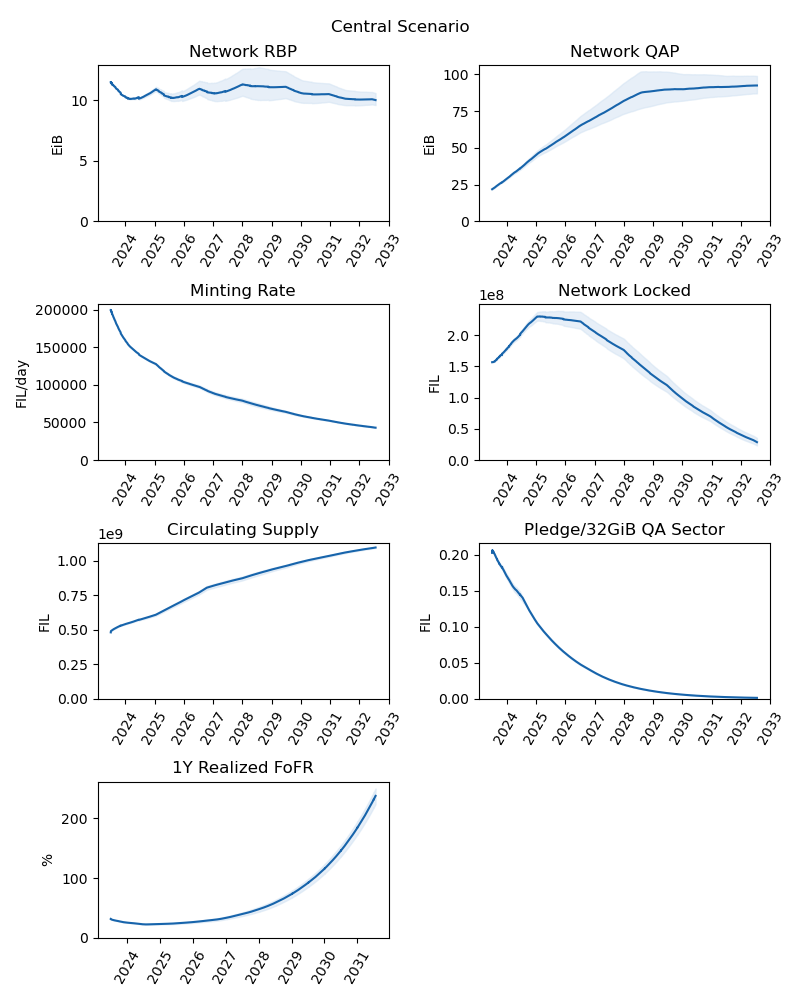

In [21]:
# plot KPIs

plt.figure(figsize=(8,10))

plt.subplot(4,2,1)
q = compute_quantiles(central_scenarios, keys=['network_RBP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network RBP')
plt.ylabel('EiB')
plt.ylim(0)

plt.subplot(4,2,2)
q = compute_quantiles(central_scenarios, keys=['network_QAP_EIB'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network QAP')
plt.ylabel('EiB')
plt.ylim(0)

plt.subplot(4,2,3)
q = compute_quantiles(central_scenarios, keys=['day_network_reward'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Minting Rate')
plt.ylabel('FIL/day')
plt.ylim(0)

plt.subplot(4,2,4)
q = compute_quantiles(central_scenarios, keys=['network_locked'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Network Locked')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,5)
q = compute_quantiles(central_scenarios, keys=['circ_supply'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,6)
q = compute_quantiles(central_scenarios, keys=['day_pledge_per_QAP'])
plt.plot(t, q[2], color=colors[0](0.8))
plt.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('Pledge/32GiB QA Sector')
plt.ylabel('FIL')
plt.ylim(0)

plt.subplot(4,2,7)
q = compute_quantiles(central_scenarios, keys=['1y_sector_roi'])
t_fofr = [start_date + timedelta(days=i) for i in range(len(q[2]))]
plt.plot(t_fofr, q[2]*100, color=colors[0](0.8))
plt.fill_between(t_fofr, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
plt.xticks(rotation=60)
plt.title('1Y Realized FoFR')
plt.ylabel('%')
plt.ylim(0)

plt.suptitle('Central Scenario')

plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'central_scenario_kpi.png'))

In [22]:
# for each sample, compute the date at which QA/RB exceeds given threshold
def get_saturation_idx(result, thresh=10):
    qa_rb_ratio = result['network_QAP_EIB'] / result['network_RBP_EIB']
    x = np.where(qa_rb_ratio >= thresh)[0]
    if len(x) > 0:
        return x[0]
    else:
        return None

def get_saturation_dates(results, thresh=10):
    dates = []
    for r in results:
        date_idx = get_saturation_idx(r, thresh)
        if date_idx is not None:
            dates.append(t[date_idx])
    return dates

<IPython.core.display.Javascript object>


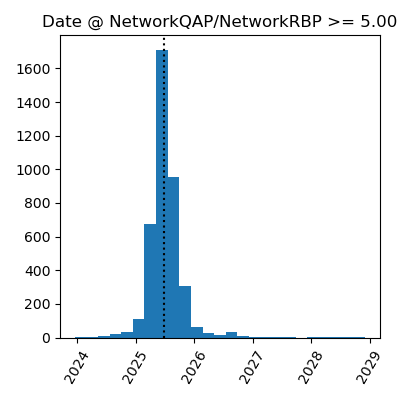

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_2936/2285209171.py:4: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  median_date = pd.to_datetime(np.quantile(pd.to_datetime(dates), 0.5, interpolation='midpoint')).to_pydatetime().date()


In [23]:
plt.figure(figsize=(4,4))
qa_rb_threshold = 5
dates = get_saturation_dates(central_scenarios, thresh=qa_rb_threshold)
median_date = pd.to_datetime(np.quantile(pd.to_datetime(dates), 0.5, interpolation='midpoint')).to_pydatetime().date()
plt.hist(dates, bins=25)
plt.axvline(median_date, color='k', linestyle=':', label='Median')
plt.xticks(rotation=60)
plt.title('Date @ NetworkQAP/NetworkRBP >= %0.02f' % (qa_rb_threshold,))
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'saturation_date.png'))

In [24]:
median_date

datetime.date(2025, 6, 24)

In [78]:
def borrowing_cost(pledge):
    return 0.1*pledge

def get_roi_cost(results, multiplier_after_policy_change=1, policy_update_idx=0, borrowing_cost_pct_filp=0.5):
    days_1y = 365
    pledge = np.asarray(results['day_pledge_per_QAP'][:1-days_1y])
    returns = np.asarray(results['1y_return_per_sector'])
    
    pledge_before_update = 10*pledge[0:policy_update_idx]
    returns_before_update = 10*returns[0:policy_update_idx]
    pledge_after_update = multiplier_after_policy_change*pledge[policy_update_idx:]
    returns_after_update = multiplier_after_policy_change*returns[policy_update_idx:]
    
    cost_before_update = borrowing_cost(pledge_before_update) / borrowing_cost_pct_filp
    if multiplier_after_policy_change == 10:
        cost_after_update = borrowing_cost(pledge_after_update) / borrowing_cost_pct_filp
    elif multiplier_after_policy_change == 1:
        fixed_cost_if_nochange = borrowing_cost(pledge[policy_update_idx:]*10)/(1-borrowing_cost_pct_filp)
        scale_cost = borrowing_cost(pledge_after_update)
        cost_after_update = scale_cost + fixed_cost_if_nochange
    roi_cost_before_update = (returns_before_update - cost_before_update) / pledge_before_update
    roi_cost_after_update = (returns_after_update - cost_after_update) / pledge_after_update
    
    roi_with_cost = np.concatenate([roi_cost_before_update, roi_cost_after_update])

    return roi_with_cost

In [88]:
## Compute counterfactuals from central scenario once the saturation threshold is reached
rbp_sweep_vec = [5, 10, 20]
filp_sweep_vec = [0, 1, 'mcmc']
saturation_idx = np.argmin(np.abs(np.asarray(t) - median_date))

# counterfactual_results = {}
cf_5_mcmc = []
cf_5_0 = []
cf_5_1 = []
cf_10_mcmc = []
cf_10_0 = []
cf_10_1 = []
cf_20_mcmc = []
cf_20_0 = []
cf_20_1 = []

for ii in tqdm(range(num_chains_mcmc*num_samples_mcmc)):
    # the original inputs which drove the central scenario
    rbp = rb_onboard_power_pred[ii]
    rr = jnp.ones(forecast_length) * smooth_historical_rr
    L = carrying_capacity[ii]
    
    # introduce change-points and rerun simulation
    for rbp_val in rbp_sweep_vec:
        for filp_val in filp_sweep_vec:
            rbp_counterfactual = jnp.copy(rbp)
            rbp_counterfactual = rbp_counterfactual.at[saturation_idx:].set(rbp_val)
            fpr_counterfactual = jnp.ones(forecast_length) * L
            if filp_val == 'mcmc':
                pass
            else:
                fpr_counterfactual = fpr_counterfactual.at[saturation_idx:].set(filp_val)

            # rerun simulation
            simulation_results = sim.run_sim(
                rbp_counterfactual,
                rr,
                fpr_counterfactual,
                lock_target,

                start_date,
                current_date,
                forecast_length,
                sector_duration,
                offline_data
            )
            if filp_val == 0:
                simulation_results['roi_with_cost'] = get_roi_cost(
                    simulation_results, 
                    multiplier_after_policy_change=1, 
                    policy_update_idx=saturation_idx
                )
            elif filp_val == 1 or filp_val == 'mcmc':
                simulation_results['roi_with_cost'] = get_roi_cost(
                    simulation_results, 
                    multiplier_after_policy_change=10, 
                    policy_update_idx=saturation_idx
                )

            if rbp_val == 5:
                if filp_val == 0:
                    cf_5_0.append(simulation_results)
                elif filp_val == 1:
                    cf_5_1.append(simulation_results)
                else:
                    cf_5_mcmc.append(simulation_results)
            elif rbp_val == 10:
                if filp_val == 0:
                    cf_10_0.append(simulation_results)
                elif filp_val == 1:
                    cf_10_1.append(simulation_results)
                else:
                    cf_10_mcmc.append(simulation_results)
            elif rbp_val == 20:
                if filp_val == 0:
                    cf_20_0.append(simulation_results)
                elif filp_val == 1:
                    cf_20_1.append(simulation_results)
                else:
                    cf_20_mcmc.append(simulation_results)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [89]:
plt_yrs = 6.5
plt_len = int(365*plt_yrs)
t = du.get_t(start_date, forecast_length=plt_len)

<IPython.core.display.Javascript object>


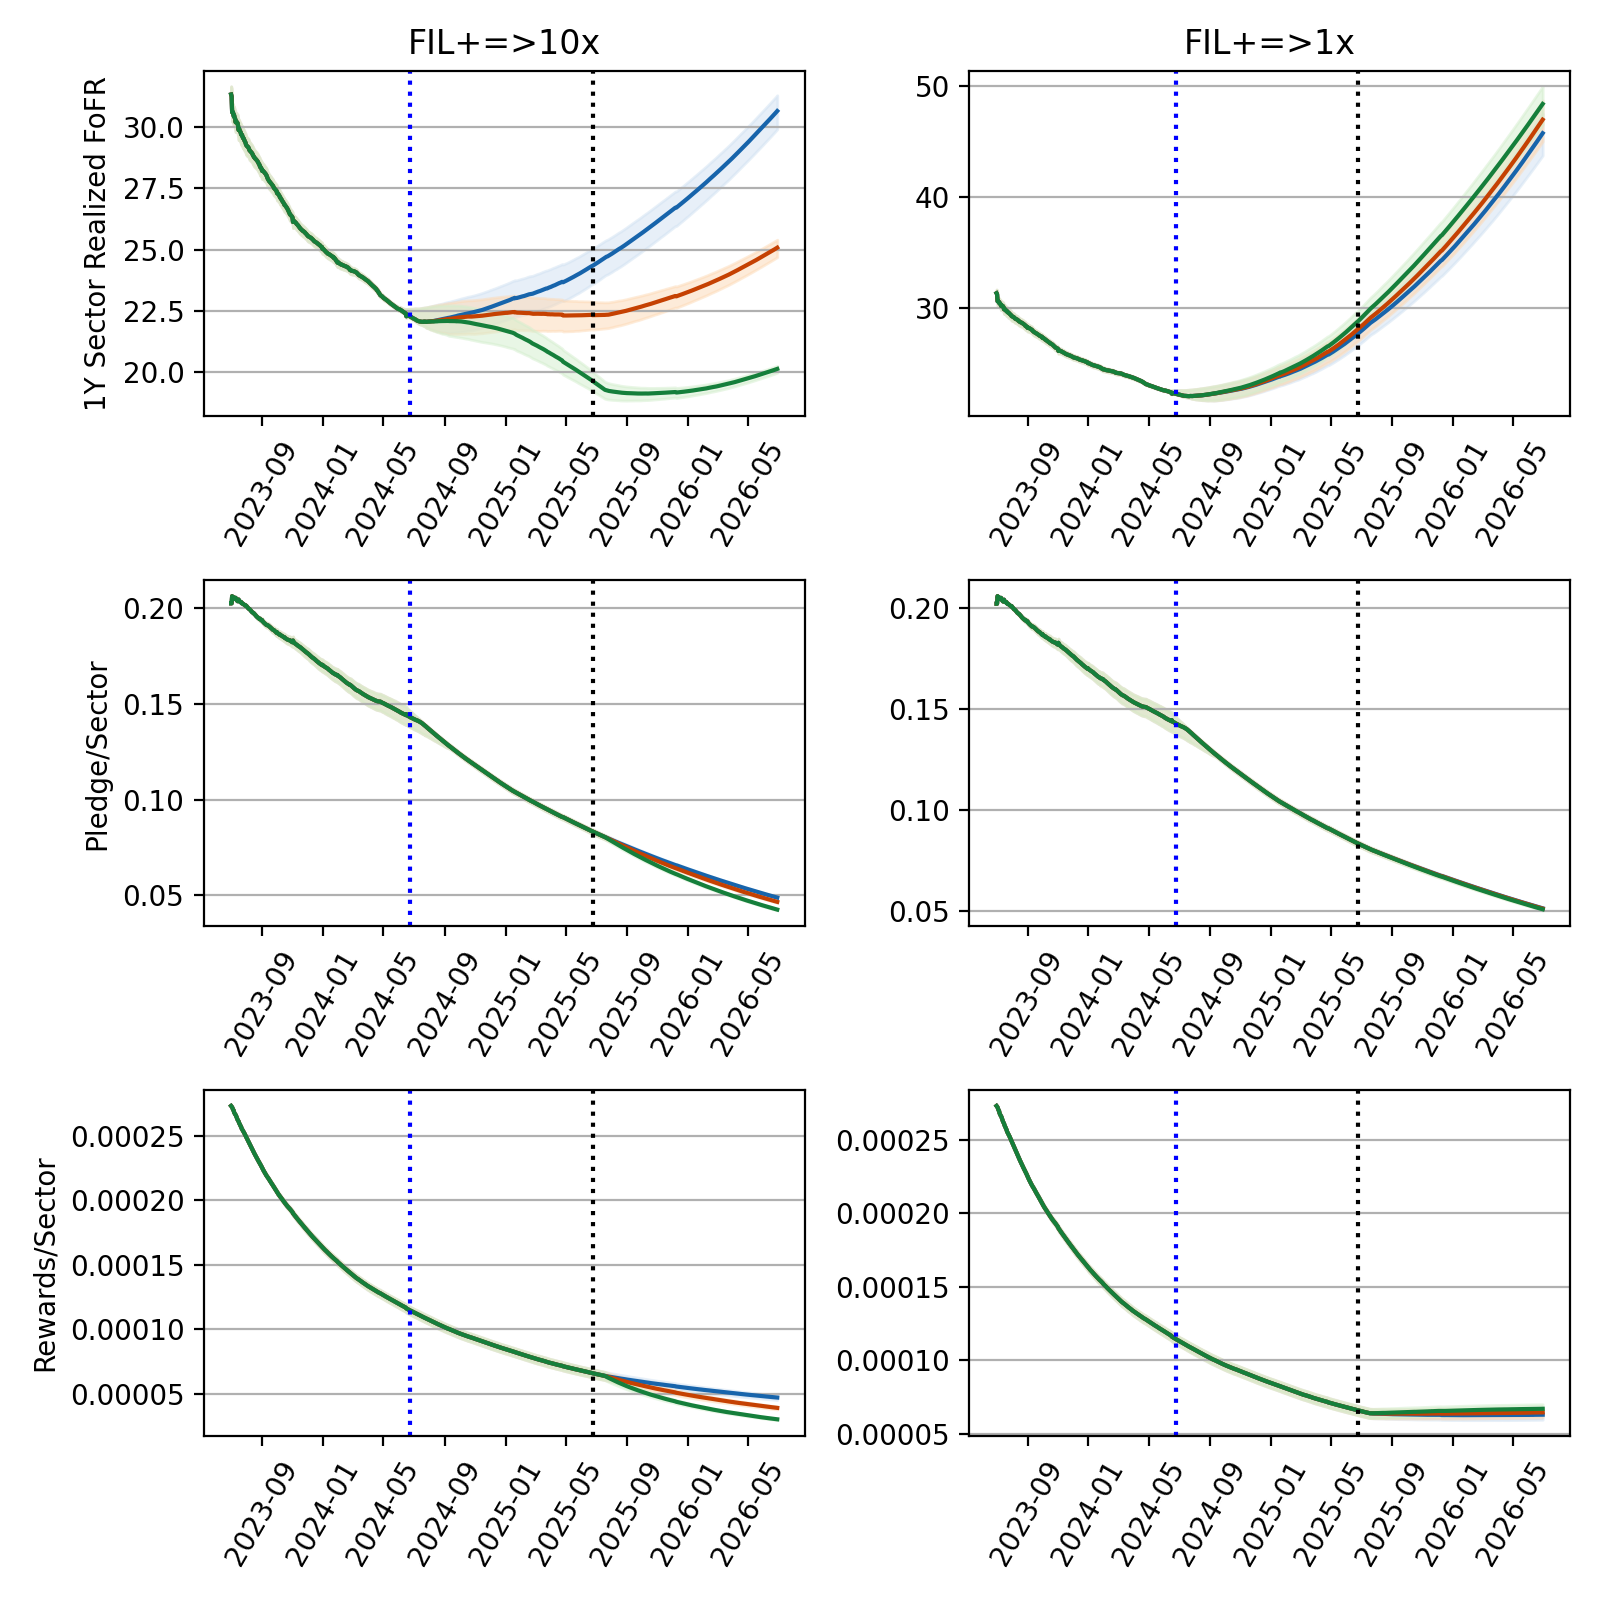

In [113]:
# temrporary plto for zoomed in FoFR w/out costs
tt = du.get_t(start_date, forecast_length=365*3)

plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
axx = plt.gca()
q = compute_quantiles(cf_5_1, keys=['1y_sector_roi'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[0](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['1y_sector_roi'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[1](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['1y_sector_roi'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[2](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.axvline(median_date-timedelta(days=365), linestyle=':', color='b')
axx.grid(axis='y')
axx.set_title('FIL+=>10x')
axx.set_ylabel('1Y Sector Realized FoFR')

plt.subplot(3,2,2)
axx = plt.gca()
q = compute_quantiles(cf_5_0, keys=['1y_sector_roi'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[0](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['1y_sector_roi'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[1](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['1y_sector_roi'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[2](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.axvline(median_date-timedelta(days=365), linestyle=':', color='b')
axx.grid(axis='y')
axx.set_title('FIL+=>1x')

plt.subplot(3,2,3)
axx = plt.gca()
q = compute_quantiles(cf_5_1, keys=['day_pledge_per_QAP'], endidx=365*3)
axx.plot(tt, q[2], color=colors[0](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['day_pledge_per_QAP'], endidx=365*3)
axx.plot(tt, q[2], color=colors[1](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['day_pledge_per_QAP'], endidx=365*3)
axx.plot(tt, q[2], color=colors[2](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.axvline(median_date-timedelta(days=365), linestyle=':', color='b')
axx.grid(axis='y')
axx.set_ylabel('Pledge/Sector')

plt.subplot(3,2,4)
axx = plt.gca()
q = compute_quantiles(cf_5_0, keys=['day_pledge_per_QAP'], endidx=365*3)
axx.plot(tt, q[2], color=colors[0](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['day_pledge_per_QAP'], endidx=365*3)
axx.plot(tt, q[2], color=colors[1](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['day_pledge_per_QAP'], endidx=365*3)
axx.plot(tt, q[2], color=colors[2](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.axvline(median_date-timedelta(days=365), linestyle=':', color='b')
axx.grid(axis='y')

plt.subplot(3,2,5)
axx = plt.gca()
q = compute_quantiles(cf_5_1, keys=['day_rewards_per_sector'], endidx=365*3)
axx.plot(tt, q[2], color=colors[0](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['day_rewards_per_sector'], endidx=365*3)
axx.plot(tt, q[2], color=colors[1](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['day_rewards_per_sector'], endidx=365*3)
axx.plot(tt, q[2], color=colors[2](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.axvline(median_date-timedelta(days=365), linestyle=':', color='b')
axx.grid(axis='y')
axx.set_ylabel('Rewards/Sector')

plt.subplot(3,2,6)
axx = plt.gca()
q = compute_quantiles(cf_5_0, keys=['day_rewards_per_sector'], endidx=365*3)
axx.plot(tt, q[2], color=colors[0](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['day_rewards_per_sector'], endidx=365*3)
axx.plot(tt, q[2], color=colors[1](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['day_rewards_per_sector'], endidx=365*3)
axx.plot(tt, q[2], color=colors[2](0.8))
axx.fill_between(tt, q[1], q[3], color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.axvline(median_date-timedelta(days=365), linestyle=':', color='b')
axx.grid(axis='y')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'fofr_zoom.png'))

<IPython.core.display.Javascript object>


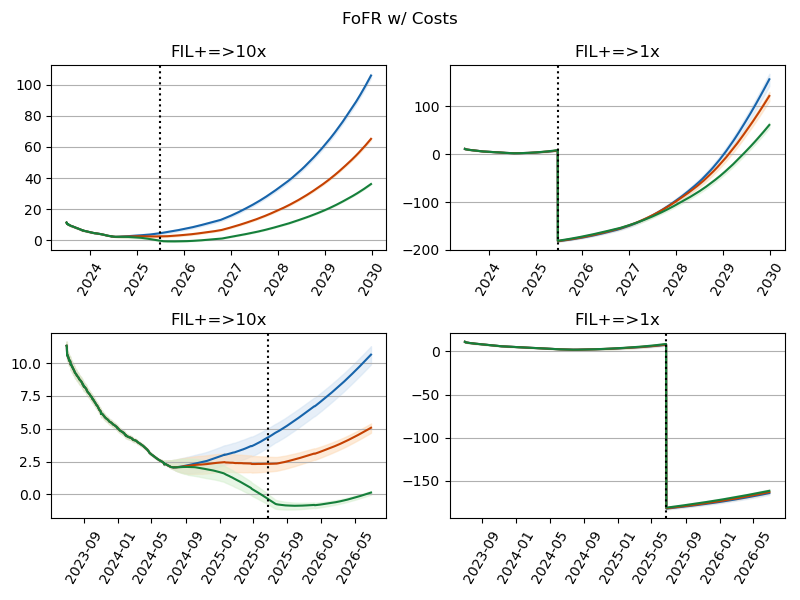

In [90]:
tt = du.get_t(start_date, forecast_length=365*3)

# temporary plot for comparing costs quickly
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
axx = plt.gca()
q = compute_quantiles(cf_5_1, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
axx.set_title('FIL+=>10x')

plt.subplot(2,2,2)
axx = plt.gca()
q = compute_quantiles(cf_5_0, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
axx.set_title('FIL+=>1x')
plt.tight_layout()

plt.subplot(2,2,3)
axx = plt.gca()
q = compute_quantiles(cf_5_1, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[0](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[1](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[2](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
axx.set_title('FIL+=>10x')

plt.subplot(2,2,4)
axx = plt.gca()
q = compute_quantiles(cf_5_0, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[0](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[1](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[2](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
axx.set_title('FIL+=>1x')

plt.suptitle('FoFR w/ Costs')

plt.tight_layout()

<IPython.core.display.Javascript object>


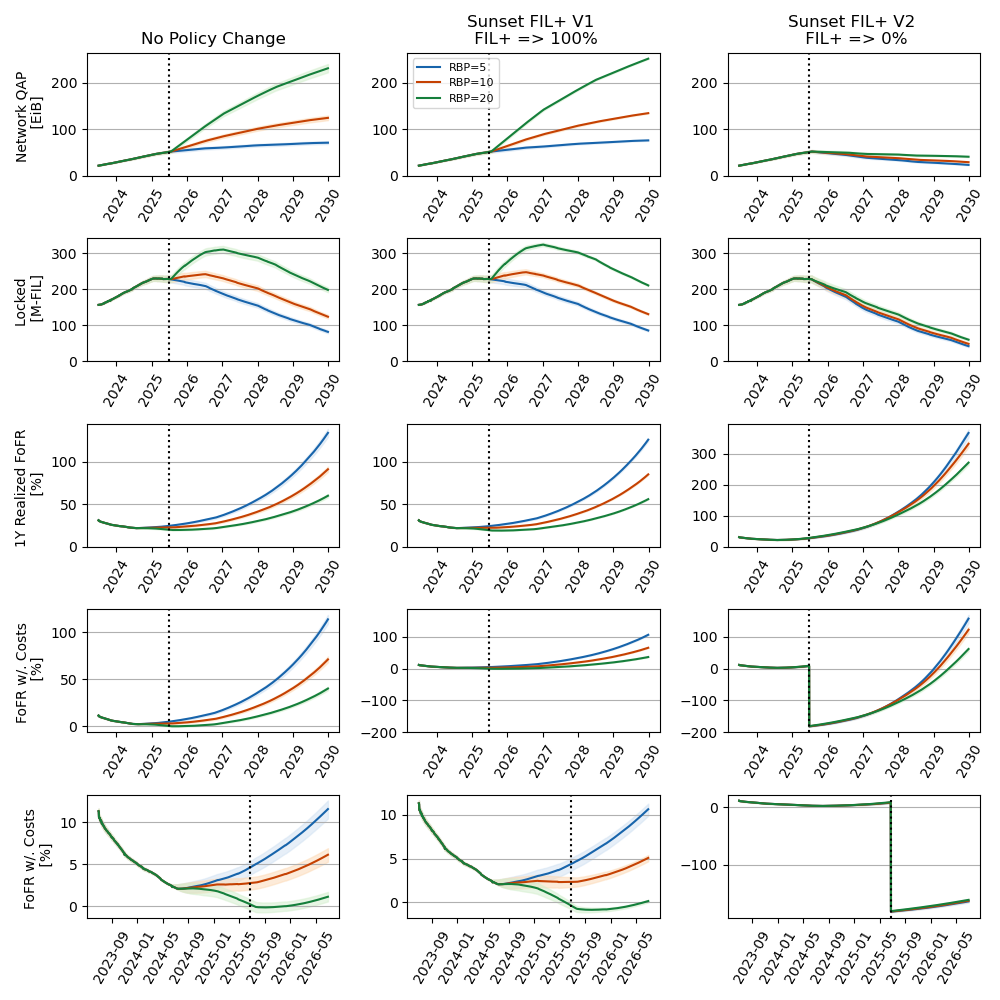

In [93]:
# generate plot within time-bounds for the report

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(10,10))

# central scenario
axx = ax[0,0]
q = compute_quantiles(cf_5_mcmc, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_mcmc, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_mcmc, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
axx.set_title('No Policy Change')
axx.set_ylabel('Network QAP \n [EiB]')
axx.set_ylim(0)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
    
axx = ax[1,0]
q = compute_quantiles(cf_5_mcmc, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_mcmc, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_mcmc, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[2](0.2), alpha=0.5)
axx.set_ylabel('Locked \n [M-FIL]')
axx.set_ylim(0)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)

axx = ax[2,0]
q = compute_quantiles(cf_5_mcmc, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_mcmc, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_mcmc, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
axx.set_ylabel('1Y Realized FoFR \n [%]')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.set_ylim(0)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')

axx = ax[3,0]
q = compute_quantiles(cf_5_mcmc, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_mcmc, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_mcmc, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
axx.set_ylabel('FoFR w/. Costs \n [%]')

axx = ax[4,0]
q = compute_quantiles(cf_5_mcmc, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[0](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_mcmc, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[1](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_mcmc, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[2](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
# axx.sharey(ax[3,0])
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
axx.set_ylabel('FoFR w/. Costs \n [%]')

# FIL+ --> 100%
axx = ax[0,1]
axx.set_title('Sunset FIL+ V1 \n FIL+ => 100%')
q = compute_quantiles(cf_5_1, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
axx.legend(fontsize=8)
axx.axvline(median_date, linestyle=':', color='k')
axx.set_ylim(0)
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)

axx = ax[1,1]
q = compute_quantiles(cf_5_1, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[0](0.8))
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[1](0.8))
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[2](0.8))
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[2](0.2), alpha=0.5)
axx.axvline(median_date, linestyle=':', color='k')
axx.set_ylim(0)
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)

axx = ax[2,1]
q = compute_quantiles(cf_5_1, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')

axx = ax[3,1]
q = compute_quantiles(cf_5_1, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
# axx.sharey(ax[3,0])
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')

axx = ax[4,1]
q = compute_quantiles(cf_5_1, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[0](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_1, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[1](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_1, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[2](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
# axx.sharey(ax[3,0])
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')

# FIL+ --> 0%
axx = ax[0,2]
axx.set_title('Sunset FIL+ V2 \n FIL+ => 0%')
q = compute_quantiles(cf_5_0, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[0](0.8))
axx.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[1](0.8))
axx.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[2](0.8))
axx.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
# axx.legend(fontsize=8)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)

axx = ax[1,2]
q = compute_quantiles(cf_5_0, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[0](0.8))
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[1](0.8))
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[2](0.8))
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[2](0.2), alpha=0.5)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)

axx = ax[2,2]
q = compute_quantiles(cf_5_0, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
# axx.set_ylim(0,100)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
    
axx = ax[3,2]
q = compute_quantiles(cf_5_0, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')

axx = ax[4,2]
q = compute_quantiles(cf_5_0, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[0](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(cf_10_0, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[1](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(cf_20_0, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[2](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
    
ax[0,0].sharey(ax[0,1])
ax[0,2].sharey(ax[0,1])
ax[1,0].sharey(ax[1,1])
ax[1,2].sharey(ax[1,1])
ax[2,0].set_ylim(0)
ax[2,1].set_ylim(0)
ax[2,1].sharey(ax[2,0])
ax[2,2].set_ylim(0)
ax[3,1].sharey(ax[3,2])
# ax[4,1].sharey(ax[4,2])
for i in range(1,4):
    for j in range(1,3):
        ax[i,j].sharex(ax[0,0])


plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'compare.png'))

In [98]:
def compute_quantiles_relative(results1, results2, keys=['network_RBP_EIB'], xform=None, q=[0.05, 0.25, 0.50, 0.75, 0.95], startidx=None, endidx=None):
    key_vec = []
    assert len(results1) == len(results2)
    
    for ii in range(len(results1)):
        r1 = results1[ii]
        r2 = results2[ii]
        tmp_res = []
        for k in keys:
            tmp_res.append(r1[k]-r2[k])
            
        if xform is None:
            key_vec.append(tmp_res[0])
        else:
            xx = xform(tmp_res)
            if xx is not None:
                key_vec.append(xx)
    key_vec = np.asarray(key_vec)
    if startidx is not None:
        key_vec = key_vec[:, startidx:]
    if endidx is not None:
        key_vec = key_vec[:, 0:endidx]
    return np.nanquantile(key_vec, q, axis=0)

<IPython.core.display.Javascript object>


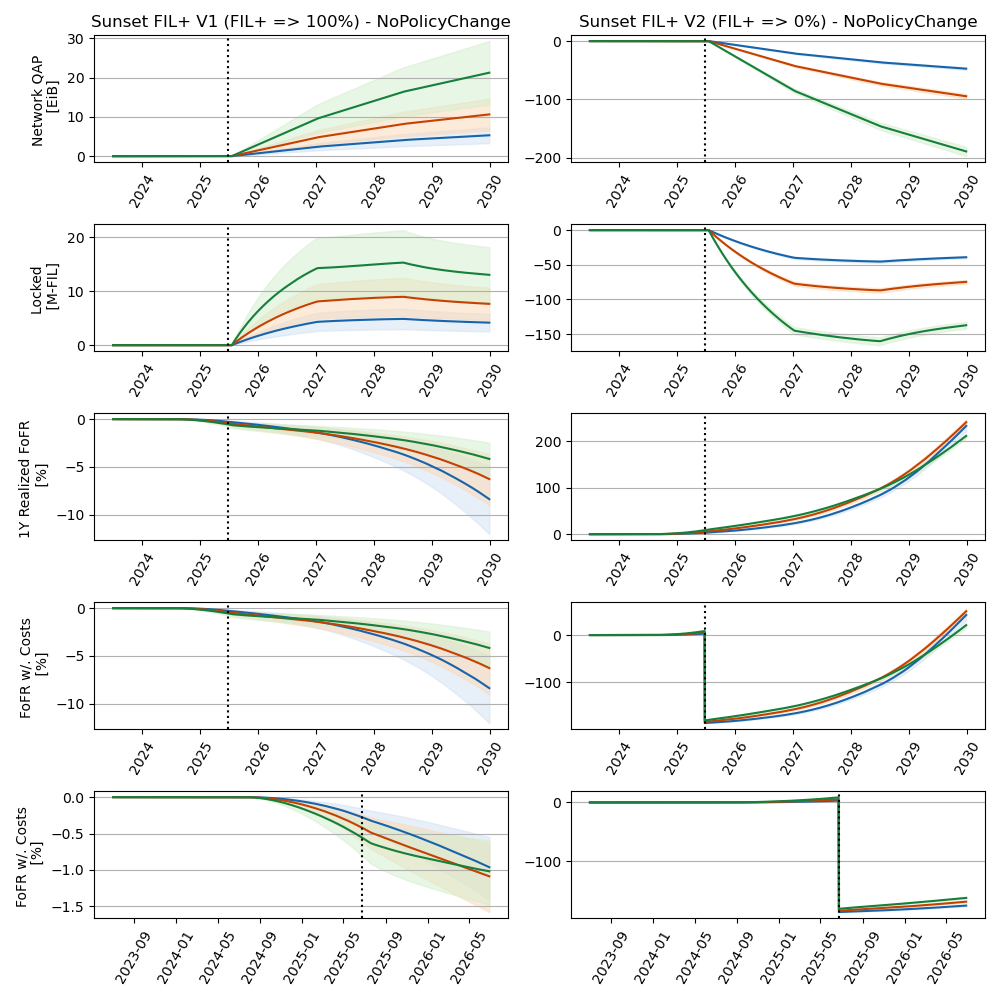

In [103]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

# central scenario
axx = ax[0,0]
q = compute_quantiles_relative(cf_5_1, cf_5_mcmc, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_1, cf_10_mcmc, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_1, cf_20_mcmc, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
axx.set_title('Sunset FIL+ V1 (FIL+ => 100%) - NoPolicyChange')
axx.set_ylabel('Network QAP \n [EiB]')
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
    
axx = ax[1,0]
q = compute_quantiles_relative(cf_5_1, cf_5_mcmc, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_1, cf_10_mcmc, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_1, cf_20_mcmc, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[2](0.2), alpha=0.5)
axx.set_ylabel('Locked \n [M-FIL]')
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)

axx = ax[2,0]
q = compute_quantiles_relative(cf_5_1, cf_5_mcmc, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_1, cf_10_mcmc, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_1, cf_20_mcmc, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
axx.set_ylabel('1Y Realized FoFR \n [%]')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')

axx = ax[3,0]
q = compute_quantiles_relative(cf_5_1, cf_5_mcmc, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_1, cf_10_mcmc, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_1, cf_20_mcmc, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
axx.set_ylabel('FoFR w/. Costs \n [%]')

axx = ax[4,0]
q = compute_quantiles_relative(cf_5_1, cf_5_mcmc, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[0](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_1, cf_10_mcmc, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[1](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_1, cf_20_mcmc, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[2](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
# axx.sharey(ax[3,0])
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
axx.set_ylabel('FoFR w/. Costs \n [%]')


axx = ax[0,1]
q = compute_quantiles_relative(cf_5_0, cf_5_mcmc, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1], q[3], color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_0, cf_10_mcmc, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1], q[3], color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_0, cf_20_mcmc, keys=['network_QAP_EIB'], endidx=plt_len)
axx.plot(t, q[2], color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1], q[3], color=colors[2](0.2), alpha=0.5)
axx.set_title('Sunset FIL+ V2 (FIL+ => 0%) - NoPolicyChange')
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
    
axx = ax[1,1]
q = compute_quantiles_relative(cf_5_0, cf_5_mcmc, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_0, cf_10_mcmc, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_0, cf_20_mcmc, keys=['network_locked'], endidx=plt_len)
axx.plot(t, q[2]/1e6, color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[2](0.2), alpha=0.5)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)

axx = ax[2,1]
q = compute_quantiles_relative(cf_5_0, cf_5_mcmc, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8), label='RBP=5')
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_0, cf_10_mcmc, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8), label='RBP=10')
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_0, cf_20_mcmc, keys=['1y_sector_roi'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8), label='RBP=20')
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')

axx = ax[3,1]
q = compute_quantiles_relative(cf_5_0, cf_5_mcmc, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[0](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_0, cf_10_mcmc, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[1](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_0, cf_20_mcmc, keys=['roi_with_cost'], endidx=plt_len)
axx.plot(t, q[2]*100, color=colors[2](0.8))
axx.fill_between(t, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')

axx = ax[4,1]
q = compute_quantiles_relative(cf_5_0, cf_5_mcmc, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[0](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_10_0, cf_10_mcmc, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[1](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles_relative(cf_20_0, cf_20_mcmc, keys=['roi_with_cost'], endidx=365*3)
axx.plot(tt, q[2]*100, color=colors[2](0.8))
axx.fill_between(tt, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
# axx.sharey(ax[3,0])
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
axx.axvline(median_date, linestyle=':', color='k')
axx.grid(axis='y')


plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'compare_relative.png'))